In [2]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(gpus[0], 'GPU')

In [4]:
pip install pandas matplotlib pillow

     ---------------------------------------- 0.0/11.3 MB ? eta -:--:--
     ---------------------------------------- 0.0/11.3 MB ? eta -:--:--
     ---------------------------------------- 0.1/11.3 MB 1.3 MB/s eta 0:00:09
      --------------------------------------- 0.2/11.3 MB 1.3 MB/s eta 0:00:09
      --------------------------------------- 0.3/11.3 MB 1.6 MB/s eta 0:00:07
     - -------------------------------------- 0.4/11.3 MB 1.9 MB/s eta 0:00:06
     - -------------------------------------- 0.5/11.3 MB 2.0 MB/s eta 0:00:06
     - -------------------------------------- 0.5/11.3 MB 2.0 MB/s eta 0:00:06
     -- ------------------------------------- 0.6/11.3 MB 1.9 MB/s eta 0:00:06
     -- ------------------------------------- 0.6/11.3 MB 1.7 MB/s eta 0:00:07
     -- ------------------------------------- 0.6/11.3 MB 1.7 MB/s eta 0:00:07
     -- ------------------------------------- 0.6/11.3 MB 1.7 MB/s eta 0:00:07
     -- ------------------------------------- 0.6/11.3 MB 1.7 MB/s


[notice] A new release of pip is available: 23.0.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
pip install scikit-learn

     ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
     ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
     ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
     ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
     ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
     ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
     ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
     ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
     ---------------------------------------- 0.1/8.9 MB 249.8 kB/s eta 0:00:36
     ---------------------------------------- 0.1/8.9 MB 249.8 kB/s eta 0:00:36
     ---------------------------------------- 0.1/8.9 MB 249.8 kB/s eta 0:00:36
      --------------------------------------- 0.2/8.9 MB 316.5 kB/s eta 0:00:28
      --------------------------------------- 0.2/8.9 MB 337.8 kB/s eta 0:00:26
     - -------------------------


[notice] A new release of pip is available: 23.0.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
# Imports
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

import tensorflow as tf
from tensorflow.keras import layers, models

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.10.0


In [ ]:
base_dir = Path("..")
data_dir = base_dir / "data" / "Infection Segmentation Data" / "Infection Segmentation Data"

train_dir = data_dir / "Train"
val_dir = data_dir / "Val"
test_dir = data_dir / "Test"

print("Train dir:", train_dir)
print("Val dir:  ", val_dir)
print("Test dir: ", test_dir)

print("Train classes:", [p.name for p in sorted(train_dir.iterdir())])

Train dir: ..\data\Infection Segmentation Data\Infection Segmentation Data\Train
Val dir:   ..\data\Infection Segmentation Data\Infection Segmentation Data\Val
Test dir:  ..\data\Infection Segmentation Data\Infection Segmentation Data\Test
Train classes: ['COVID-19', 'Non-COVID', 'Normal']


In [ ]:

def collect_pairs(split_dir: Path) -> pd.DataFrame:
    pairs = []
    for class_dir in sorted(split_dir.iterdir()): 
        images_dir = class_dir / "images"
        masks_dir = class_dir / "infection masks"
        if not images_dir.exists() or not masks_dir.exists():
            continue

        for img_path in images_dir.glob("*.png"):
            mask_path = masks_dir / img_path.name
            if mask_path.exists():
                pairs.append(
                    {
                        "class": class_dir.name,
                        "image": img_path,
                        "mask": mask_path,
                    }
                )
    return pd.DataFrame(pairs)

train_df = collect_pairs(train_dir)
val_df = collect_pairs(val_dir)

print("Train samples:", len(train_df))
print("Val samples:  ", len(val_df))
train_df.head()

Train samples: 3728
Val samples:   932


,class,image,mask
0,COVID-19,..\data\Infection Segmentation Data\Infection ...,..\data\Infection Segmentation Data\Infection ...
1,COVID-19,..\data\Infection Segmentation Data\Infection ...,..\data\Infection Segmentation Data\Infection ...
2,COVID-19,..\data\Infection Segmentation Data\Infection ...,..\data\Infection Segmentation Data\Infection ...
3,COVID-19,..\data\Infection Segmentation Data\Infection ...,..\data\Infection Segmentation Data\Infection ...
4,COVID-19,..\data\Infection Segmentation Data\Infection ...,..\data\Infection Segmentation Data\Infection ...


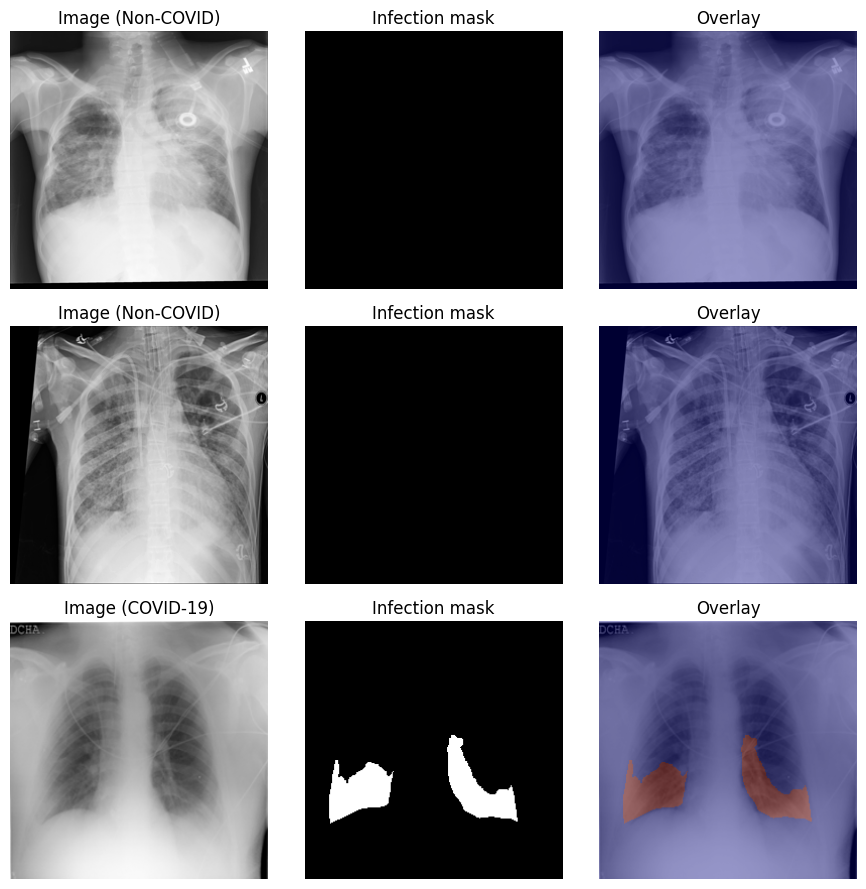

In [ ]:

N_SHOW = 3

fig, axes = plt.subplots(N_SHOW, 3, figsize=(9, 3 * N_SHOW))

for i in range(N_SHOW):
    row = train_df.sample(1, random_state=42 + i).iloc[0]
    img = np.array(Image.open(row["image"]).convert("L"))
    mask = np.array(Image.open(row["mask"]).convert("L"))

    axes[i, 0].imshow(img, cmap="gray")
    axes[i, 0].set_title(f"Image ({row['class']})")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(mask, cmap="gray")
    axes[i, 1].set_title("Infection mask")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(img, cmap="gray")
    axes[i, 2].imshow(mask, cmap="jet", alpha=0.4)
    axes[i, 2].set_title("Overlay")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()

## U-net




In [ ]:

IMG_SIZE = (256, 256)  
BATCH_SIZE = 4         

def load_pair(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=1)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, IMG_SIZE, method="nearest")
    mask = tf.cast(mask > 127, tf.float32)  # 0/1 mask

    return img, mask


def df_to_dataset(df: pd.DataFrame, shuffle=True):
    images = df["image"].astype(str).values
    masks = df["mask"].astype(str).values

    ds = tf.data.Dataset.from_tensor_slices((images, masks))
    ds = ds.map(
        lambda im, ma: load_pair(im, ma),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df))
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = df_to_dataset(train_df, shuffle=True)
val_ds = df_to_dataset(val_df, shuffle=False)

train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))>

In [ ]:
# simple U-Net 

def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    return x

inputs = layers.Input(shape=IMG_SIZE + (1,))

c1 = conv_block(inputs, 32)
p1 = layers.MaxPooling2D()(c1)

c2 = conv_block(p1, 64)
p2 = layers.MaxPooling2D()(c2)

c3 = conv_block(p2, 128)
p3 = layers.MaxPooling2D()(c3)

b = conv_block(p3, 256)


u3 = layers.UpSampling2D()(b)
u3 = layers.Concatenate()([u3, c3])
cd3 = conv_block(u3, 128)

u2 = layers.UpSampling2D()(cd3)
u2 = layers.Concatenate()([u2, c2])
cd2 = conv_block(u2, 64)

u1 = layers.UpSampling2D()(cd2)
u1 = layers.Concatenate()([u1, c1])
cd1 = conv_block(u1, 32)

outputs = layers.Conv2D(1, 1, activation="sigmoid")(cd1)

model = models.Model(inputs, outputs)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"],  
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
EPOCHS = 30  

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
)

Epoch 1/30
932/932 [==============================] - 57s 52ms/step - loss: 0.2370 - accuracy: 0.9231 - val_loss: 0.2062 - val_accuracy: 0.9307
Epoch 2/30
932/932 [==============================] - 51s 52ms/step - loss: 0.2036 - accuracy: 0.9302 - val_loss: 0.1895 - val_accuracy: 0.9307
Epoch 3/30
932/932 [==============================] - 52s 52ms/step - loss: 0.1793 - accuracy: 0.9302 - val_loss: 0.1617 - val_accuracy: 0.9307
Epoch 4/30
932/932 [==============================] - 52s 52ms/step - loss: 0.1621 - accuracy: 0.9318 - val_loss: 0.1529 - val_accuracy: 0.9334
Epoch 5/30
932/932 [==============================] - 52s 52ms/step - loss: 0.1510 - accuracy: 0.9352 - val_loss: 0.1397 - val_accuracy: 0.9376
Epoch 6/30
932/932 [==============================] - 53s 52ms/step - loss: 0.1404 - accuracy: 0.9393 - val_loss: 0.1345 - val_accuracy: 0.9402
Epoch 7/30
932/932 [==============================] - 52s 52ms/step - loss: 0.1316 - accuracy: 0.9426 - val_loss: 0.1210 - val_accuracy:

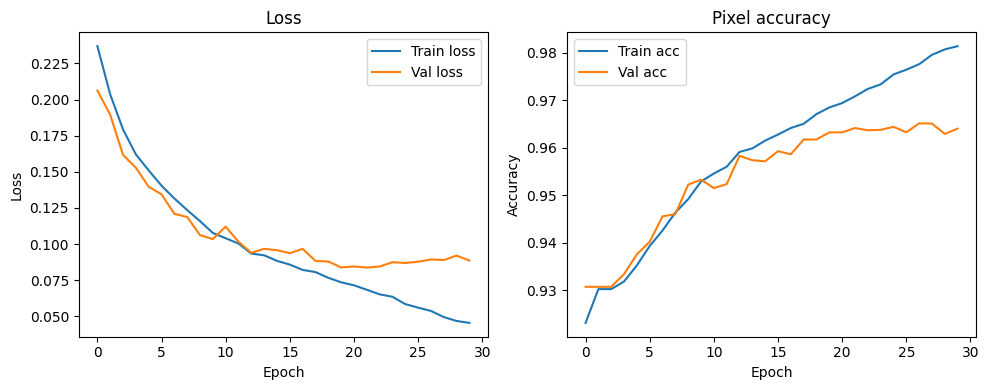

In [ ]:

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train loss")
plt.plot(history.history["val_loss"], label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Train acc")
plt.plot(history.history["val_accuracy"], label="Val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Pixel accuracy")

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 236ms/step


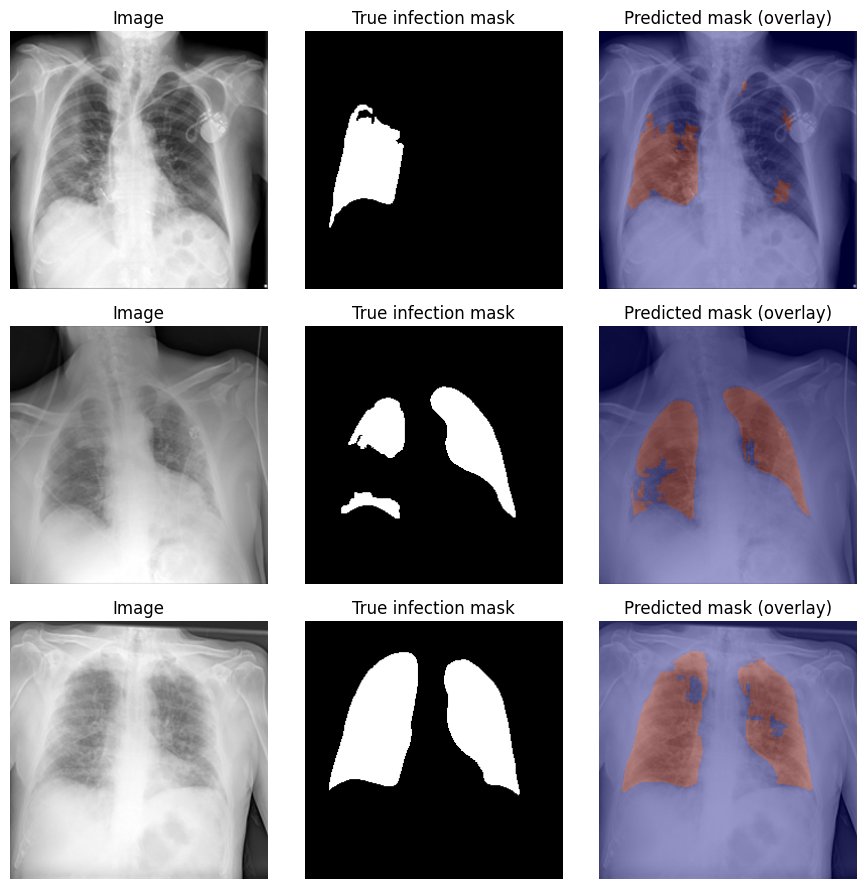

In [ ]:

val_batch = next(iter(val_ds))
imgs, true_masks = val_batch
pred_masks = model.predict(imgs)

N_SHOW = min(3, imgs.shape[0])

fig, axes = plt.subplots(N_SHOW, 3, figsize=(9, 3 * N_SHOW))

for i in range(N_SHOW):
    img = imgs[i, ..., 0]
    true_mask = true_masks[i, ..., 0]
    pred_mask = pred_masks[i, ..., 0]

    axes[i, 0].imshow(img, cmap="gray")
    axes[i, 0].set_title("Image")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(true_mask, cmap="gray")
    axes[i, 1].set_title("True infection mask")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(img, cmap="gray")
    axes[i, 2].imshow(pred_mask > 0.5, cmap="jet", alpha=0.4)
    axes[i, 2].set_title("Predicted mask (overlay)")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()